In [1]:
import time
from itertools import tee
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import holidays
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as mp
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
def GetDatePairs(start,end):
    us_holidays = holidays.financial_holidays('NYSE') 
    daterange = pd.bdate_range(start=start,end=end)
    daterange = [c for c in daterange if c not in us_holidays]
    a1, a2 = tee(daterange)
    next(a2)
    pairs = list((z[0].to_pydatetime(),z[1].to_pydatetime()) for z in zip(a1, a2))
    return pairs

In [3]:
snp500 = pd.read_csv('./data/sp500_companies.csv')

In [4]:
latest = None
B = None

In [5]:
filepath = Path("./dailies/latest.csv")
if(True==filepath.is_file()):
    latest = pd.read_csv("./dailies/latest.csv")
    B = GetDatePairs(start=(datetime.strptime(latest.duration.values[-1],"%Y-%m-%d")),end=(datetime.today()-timedelta(days=1)).strftime("%Y-%m-%d"))
    latest.duration  = pd.to_datetime(latest.duration ) 
else:
    B = GetDatePairs(start=(datetime.strptime('2024-11-01',"%Y-%m-%d")-timedelta(days=1)).strftime("%Y-%m-%d"),end=(datetime.today()-timedelta(days=1)).strftime("%Y-%m-%d"))
if(len(B)>0):
    print(f"Start: {B[0][0]}, End:{B[-1][1]}")
 



Start: 2025-08-12 00:00:00, End:2025-08-13 00:00:00


In [6]:
def GrabData(throttle=.2):
    modeltype = 'close'
    target = 'Close'
    allspy = [1.]
    alltoppercentages = [1.]
    alltopnumbers = [0.]
    allbottompercentages = [1.]
    allbottomnumbers = [0.]
    allbottompercentages = [1.]

    duration = None
    
    for  (start, end) in tqdm(B):
        #print(start.strftime("%Y-%m-%d"),end.strftime("%Y-%m-%d"))
        
        spy = []
        toppercentages = []
        topnumbers = []
        bottompercentages = []
        bottomnumbers = []
        topfileformat = './dailies/top_{0}_{1}_{2}.csv'
        bottomfileformat = './dailies/bottom_{0}_{1}_{2}.csv'
        topsyms = pd.read_csv(topfileformat.format(modeltype,start.strftime("%Y-%m-%d"),end.strftime("%Y-%m-%d")))
        topnumbers = topsyms.shape[0]
        topsyms = topsyms.Sym.values

        stock = yf.Ticker('^GSPC')
        stockhist = stock.history(start=start,end=end+timedelta(days=1))
        x = stockhist[[target]].copy().pct_change(fill_method=None)+1
        x = x.dropna()

        if(x.shape[0]==0):
            break
        
        if(duration is None):
            duration= [start]
        duration.append(end)
        spy.append(x[target].values[0])


        for sym in topsyms:
            stock = yf.Ticker(sym)
            stockhist = stock.history(start=start,end=end+timedelta(days=1))
            time.sleep(throttle)
            x = stockhist[[target]].copy().pct_change(fill_method=None)+1
            x = x.dropna()
            if((x is not None) & (x.shape[0]>0)):
                toppercentages.append(x[target].values[0])
            else:
                print(start,end,sym)

        bottomsyms = pd.read_csv(bottomfileformat.format(modeltype,start.strftime("%Y-%m-%d"),end.strftime("%Y-%m-%d")))
        bottomnumbers = (bottomsyms.shape[0])
        bottomsyms = bottomsyms.Sym.values

        for sym in bottomsyms:
            stock = yf.Ticker(sym)
            stockhist = stock.history(start=start,end=end+timedelta(days=1))
            time.sleep(throttle)
            x = stockhist[[target]].copy().pct_change()+1
            x = x.dropna()
            if((x is not None) & (x.shape[0]>0)):
                bottompercentages.append(x[target].values[0])
            else:
                print(start,end,sym)

        allspy.append(np.mean(spy))
        if(len(toppercentages)==0):
            toppercentages = [1.]
        if(np.mean(toppercentages)<.95):
             print(start, end, topsyms,toppercentages)
        alltoppercentages.append(np.mean(toppercentages))
        if(len(bottompercentages)==0):
            bottompercentages = [1.]

        allbottompercentages.append(np.mean(bottompercentages))
        alltopnumbers.append(topnumbers)
        allbottomnumbers.append(bottomnumbers)

    return (duration,allspy,alltoppercentages,allbottompercentages, alltopnumbers, allbottomnumbers)

In [7]:
#(duration,allspy,alltoppercentages,allbottompercentages) = GrabData()
(duration,allspy,alltoppercentages,allbottompercentages, alltopnumbers, allbottomnumbers) = GrabData()

  0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
x = pd.DataFrame(data={"duration":duration,"allspy":allspy,"alltoppercentages":alltoppercentages,
                       "allbottompercentages":allbottompercentages,"alltopnumbers":alltopnumbers, "allbottomnumbers":allbottomnumbers})
if((latest is not None)and(x.shape[0]>1)):
    x = pd.concat([latest,x.loc[x.duration.values>latest.duration.values[-1],:]]).reset_index(drop=True)
    x = x.drop_duplicates(ignore_index=True)
x.to_csv("./dailies/latest.csv",index=False)

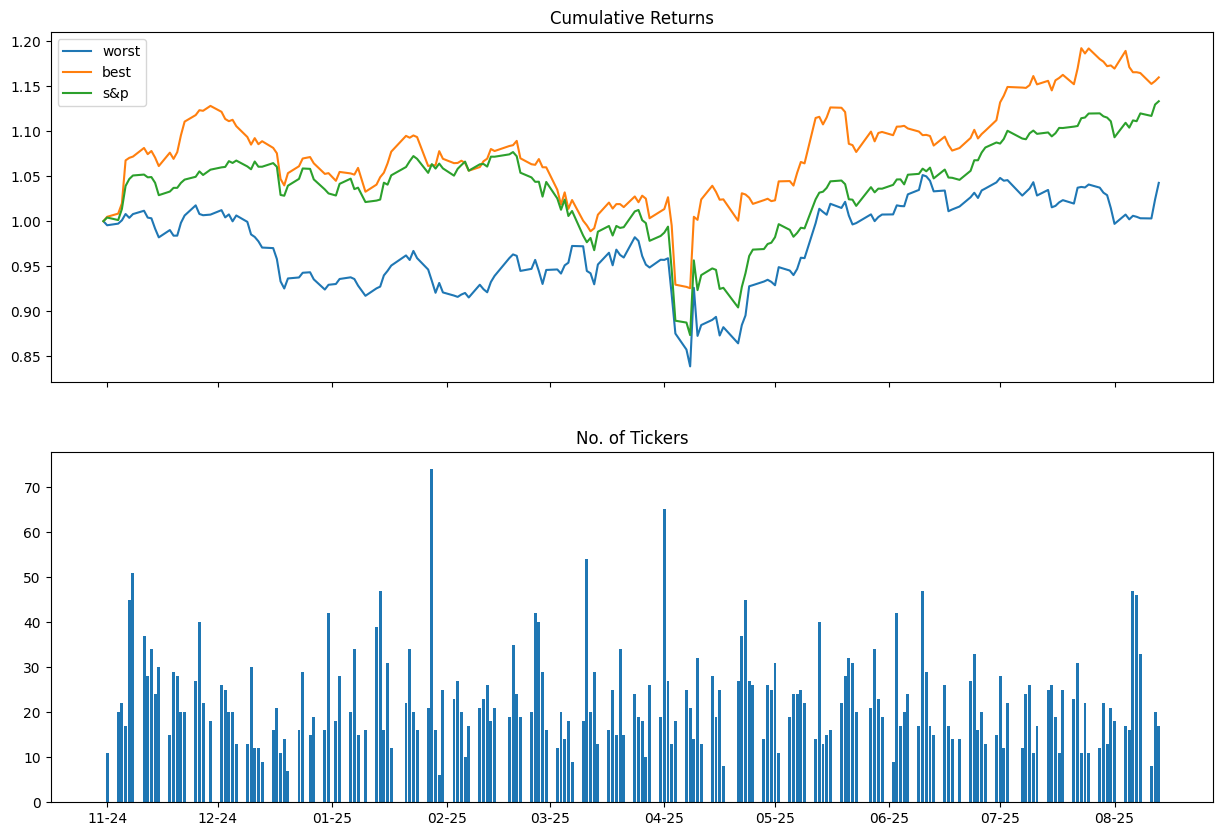

In [9]:
fig, (ax1, ax2) = mp.subplots(nrows=2, sharex=True,figsize=(15, 10))
ax1.plot(x.duration,np.cumprod(x.allbottompercentages),label='worst')
ax1.plot(x.duration,np.cumprod(x.alltoppercentages),label='best')
ax1.plot(x.duration,np.cumprod(x.allspy),label='s&p')

date_form = DateFormatter("%m-%y")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2.bar(x.duration[1:], x.alltopnumbers[1:])
ax2.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

ax1.set(xlabel=None,
       ylabel=None,
       title="Cumulative Returns")
ax2.set(xlabel=None,
       ylabel=None,
       title="No. of Tickers")

ax1.legend()

mp.show()

In [10]:
duration[-1]

datetime.datetime(2025, 8, 13, 0, 0)